this code plots blink durations, interblink intervals distributions & relationships between blink onsets and saccade/fixation onsets

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt


### Blinks descriptive stats ###

In [ ]:

base_path = 
all_durations = [] # to collect all durations
session_durations = {} # to collect duration per session
blink_rates_data = [] # to collect blink rates
all_interblink_intervals = [] # to collect all interblink intervals
session_interblink_intervals = {} # to collect intervals per session

# loading files
for folder in os.listdir(base_path):
    participant_path = os.path.join(base_path, folder)
    if not os.path.isdir(participant_path):
        continue
    blinks_path = os.path.join(participant_path, 'blinks.csv')
    if not os.path.exists(blinks_path):
        continue
    try:
        df = pd.read_csv(blinks_path)
    except Exception as e:
        print('Failed to read', blinks_path, e)
        continue
    
    if 'duration [ms]' in df.columns and len(df) > 0:
        vals = pd.to_numeric(df['duration [ms]'], errors='coerce').dropna().tolist()
        all_durations.extend(vals)
        session_durations[folder] = vals
        
        # Calculate blink rate and recording duration
        rec_period = df['end timestamp [ns]'].iloc[-1] - df['start timestamp [ns]'].iloc[0]
        rec_minutes = rec_period / 1e9 / 60 # bc originally ts are in nanoseconds
        blink_rate = len(df) / rec_minutes
        blink_rates_data.append({'Recording': folder, 'Rate': blink_rate, 'N_Blinks': len(df)})
        
        # Calculate interblink intervals (time between consecutive blinks)
        start_times = pd.to_numeric(df['start timestamp [ns]'], errors='coerce').dropna().sort_values()
        if len(start_times) > 1:
            intervals_ns = np.diff(start_times)
            intervals_sec = intervals_ns / 1e9  # convert to seconds
            intervals_ms = intervals_sec * 1000  # convert to milliseconds
            all_interblink_intervals.extend(intervals_ms)
            session_interblink_intervals[folder] = intervals_ms.tolist()

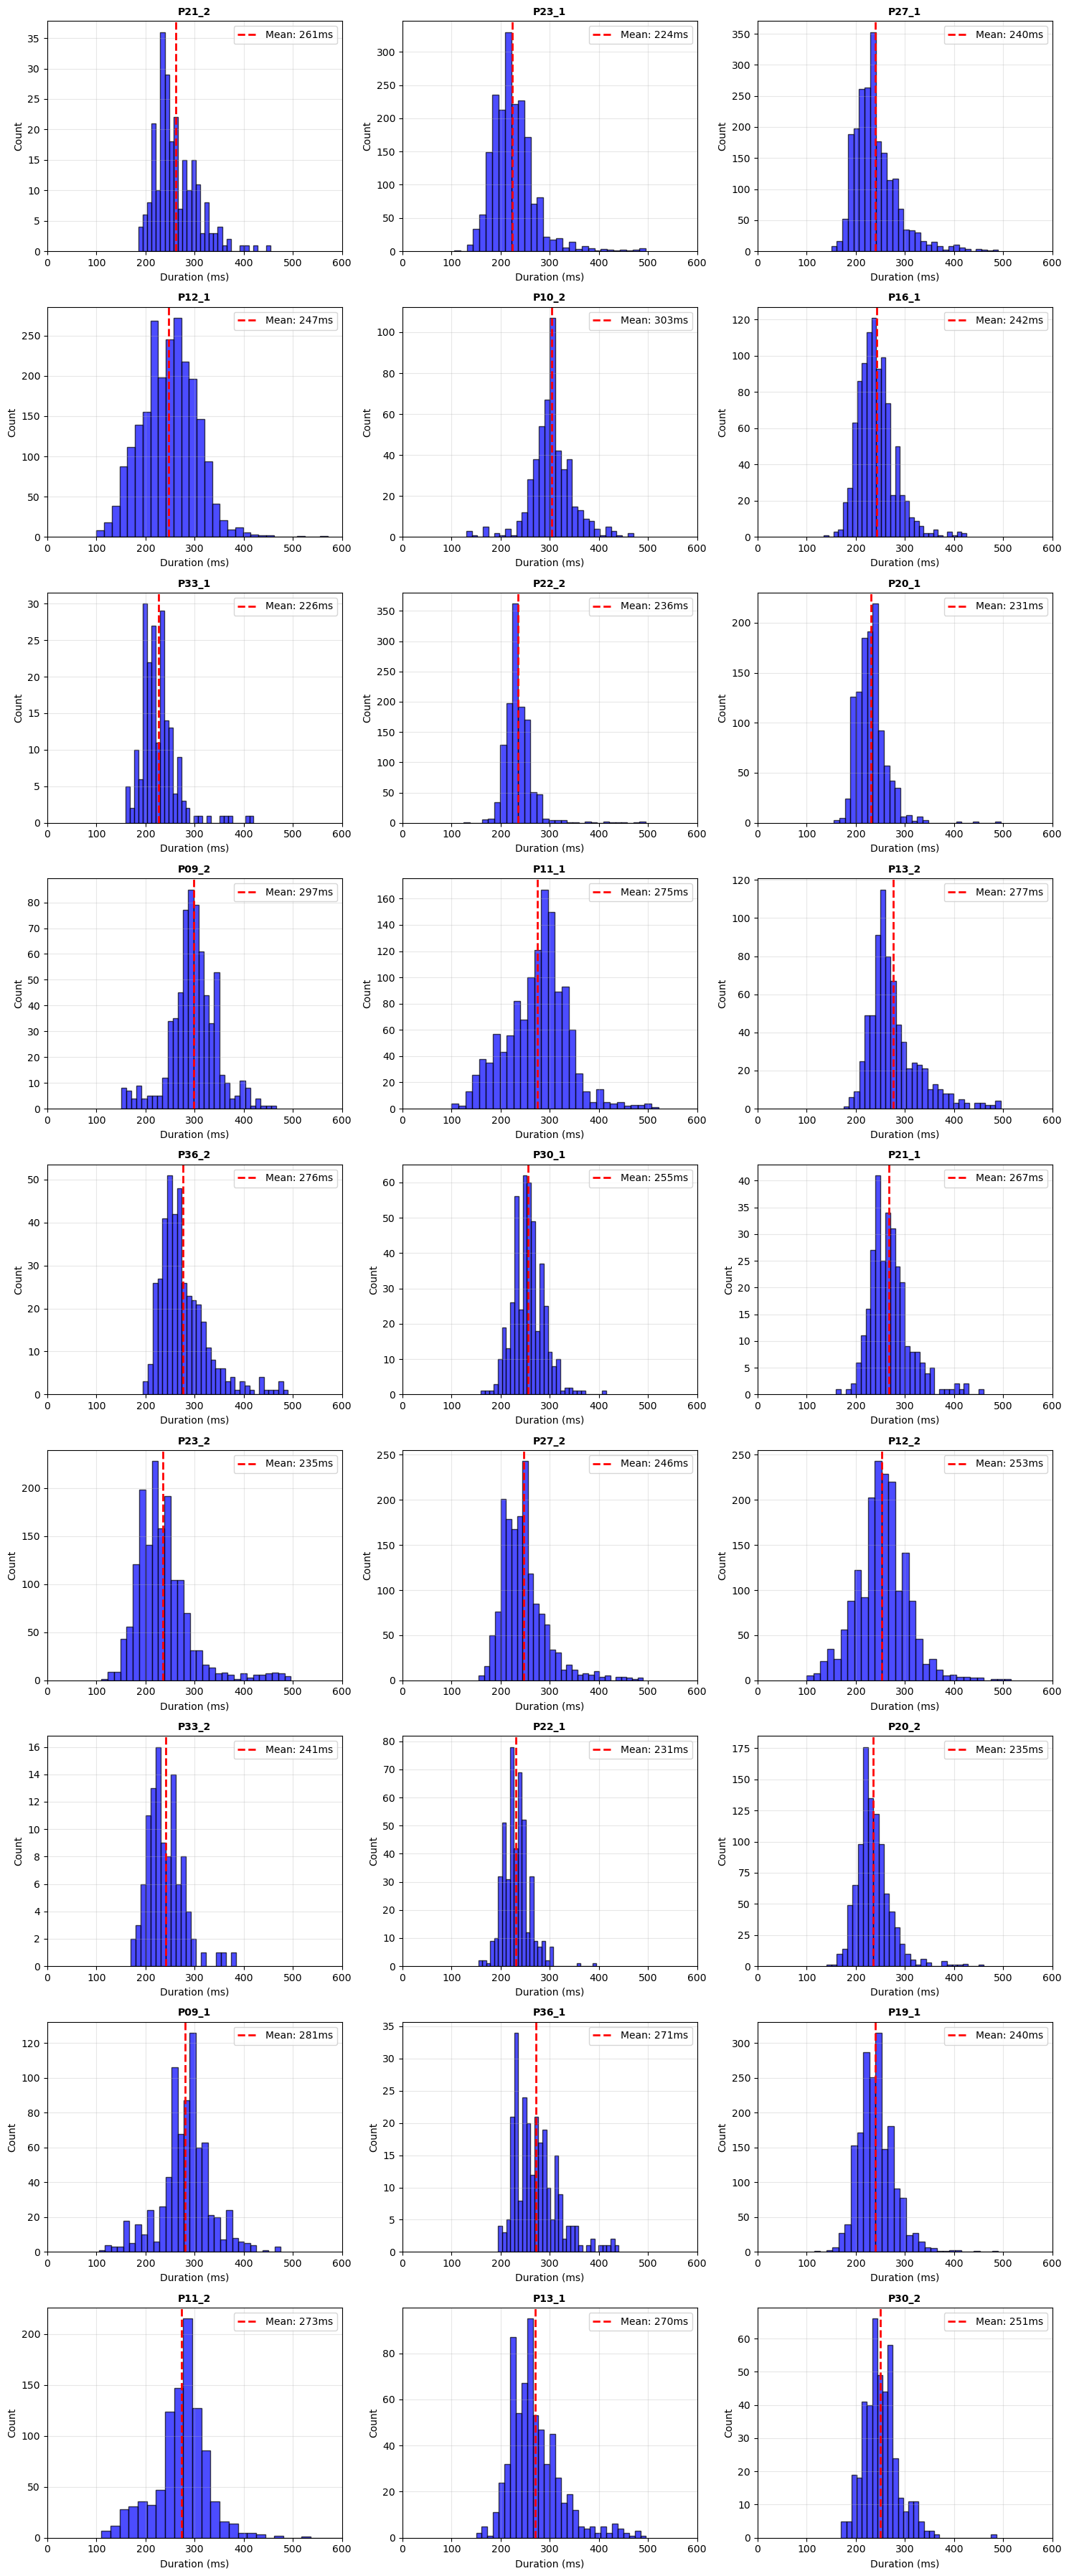

In [ ]:
# DURATION DISTRIBUTIONS PER SESSION

# arranging figures
n_recordings = len(session_durations)
n_cols = 3
n_rows = ceil(n_recordings / n_cols)

fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_recordings == 1:
    axes1 = [axes1]
elif n_rows == 1:
    axes1 = [axes1]
else:
    axes1 = axes1.flatten()

recording_names = list(session_durations.keys())

for i, (recording, durations) in enumerate(session_durations.items()):
    ax = axes1[i]
    if len(durations) > 0:
        mean_dur = np.mean(durations)
        ax.hist(durations, bins=min(30, len(durations)//5), 
                color='blue', alpha=0.7, edgecolor='black')
        ax.axvline(mean_dur, color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {mean_dur:.0f}ms')
        ax.set_title(f'{recording[:12]}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Duration (ms)')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 600)
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

for i in range(len(session_durations), len(axes1)):
    axes1[i].set_visible(False)

plt.tight_layout()
plt.show()

/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_41579/1536308284.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=all_interblink_intervals_sec, ax=ax_box, palette="pastel")


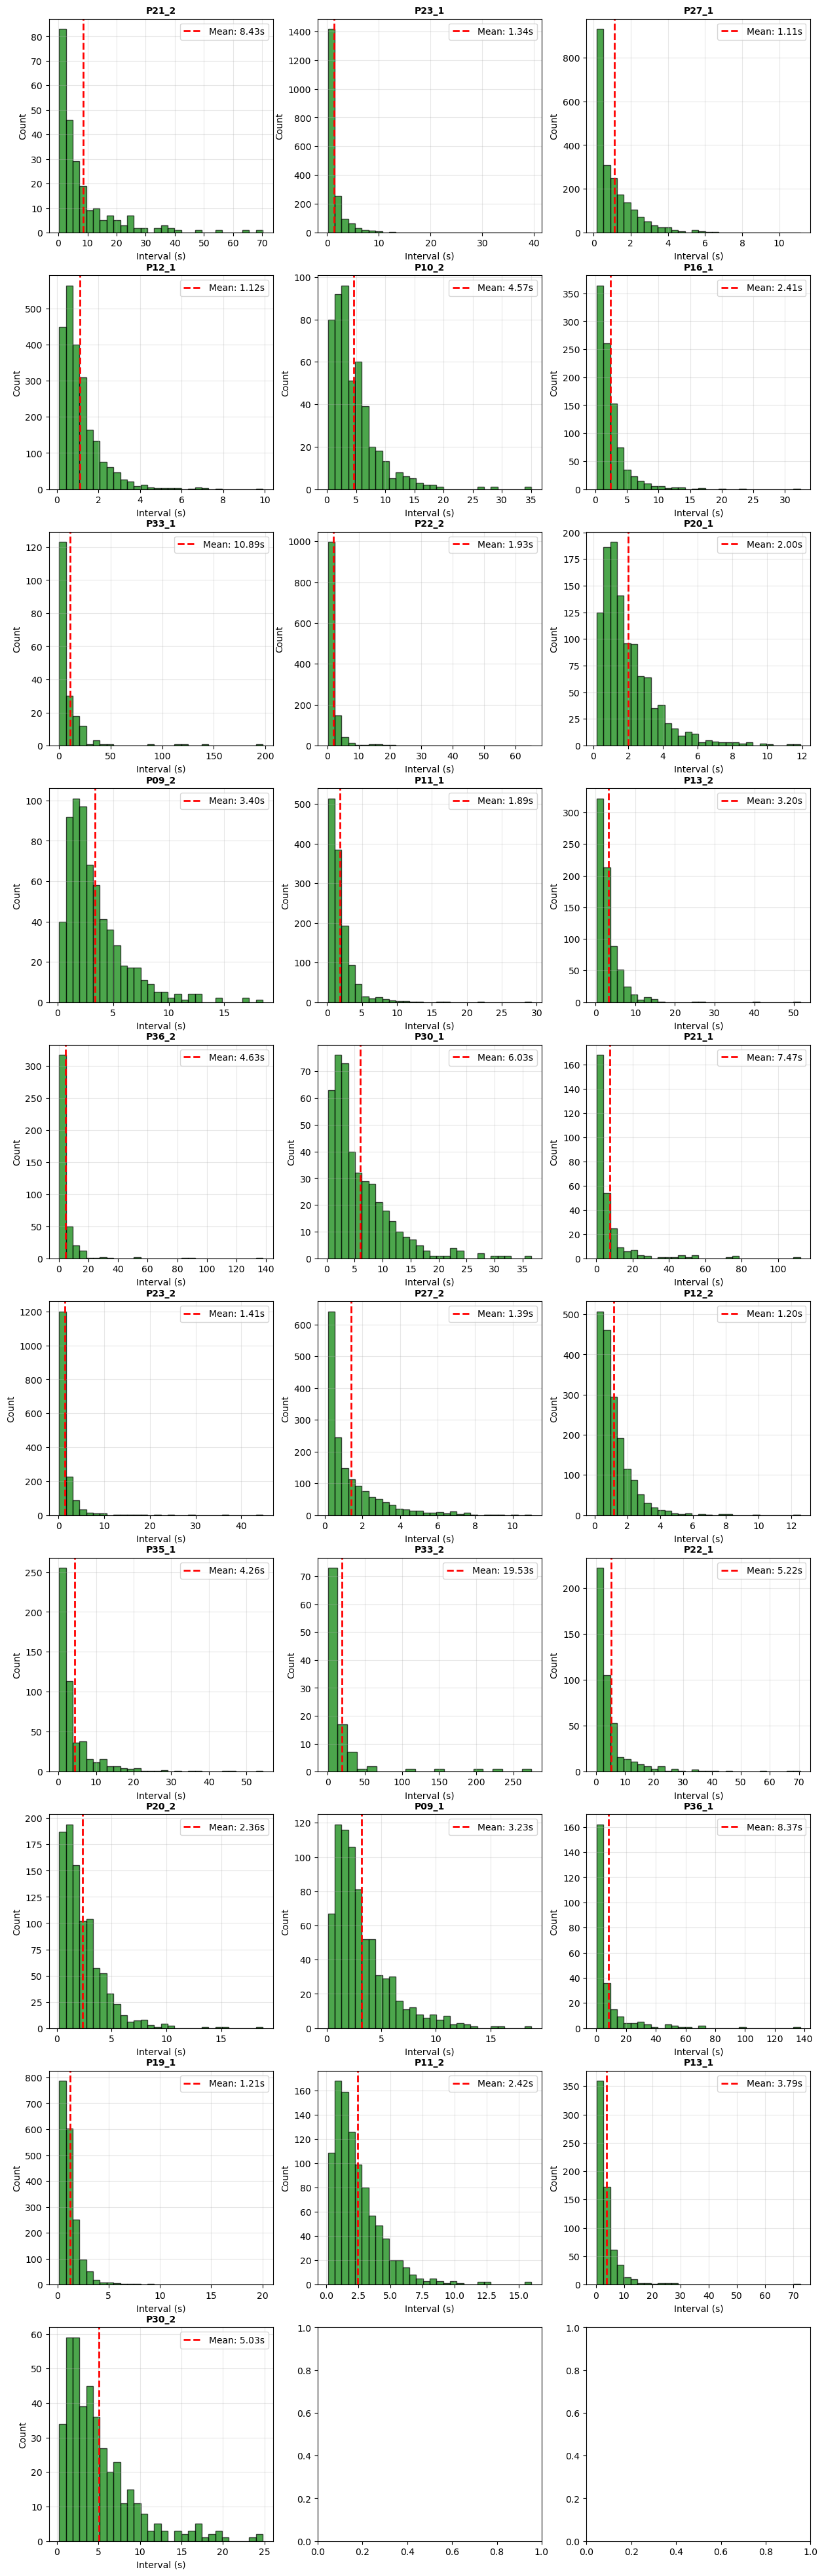

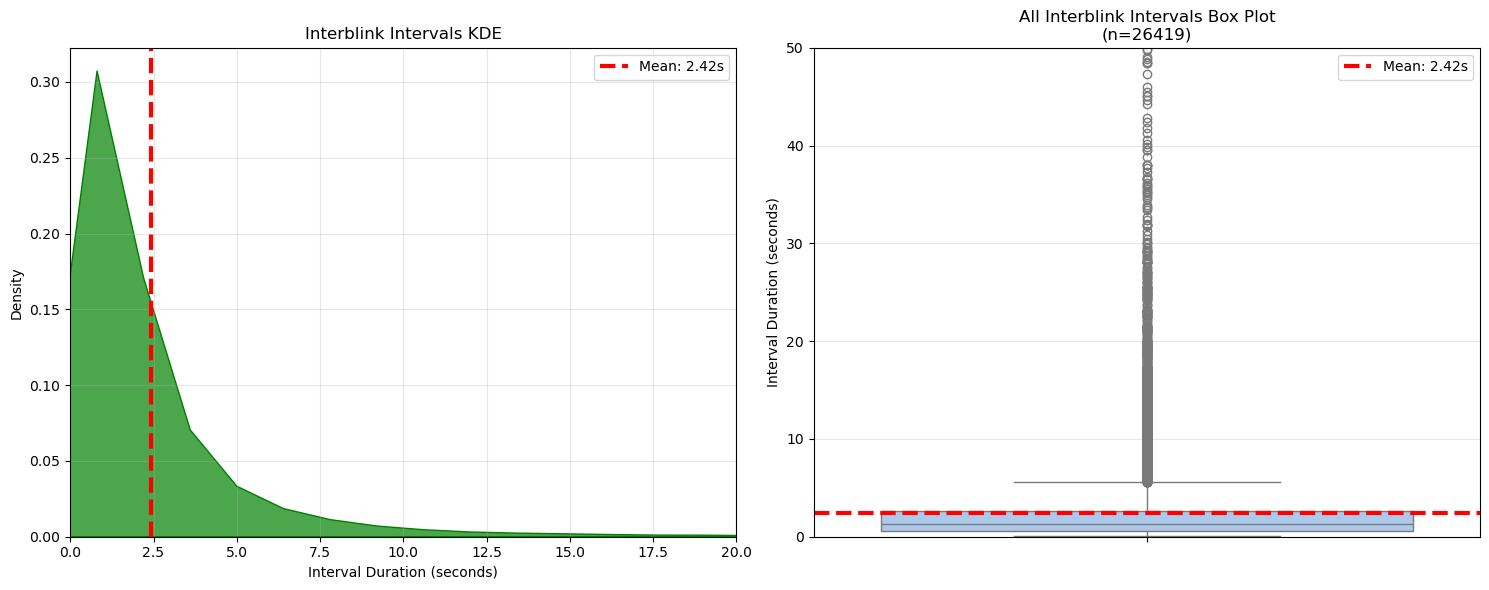

NTERBLINK INTERVALS (SECONDS)
Total intervals: 26419
Mean: 2.42 ± 5.38 s
Range: 0.11 - 274.40 s


In [ ]:
# INTERBLINK INTERVALS

# Convert all interblink intervals to seconds
all_interblink_intervals_sec = np.array(all_interblink_intervals) / 1000  # ms to seconds
session_interblink_intervals_sec = {}
for session, intervals in session_interblink_intervals.items():
    session_interblink_intervals_sec[session] = np.array(intervals) / 1000 

# Histogram of interblink intervals per session
n_sessions = len(session_interblink_intervals_sec)
n_cols = 3
n_rows = ceil(n_sessions / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
if n_sessions == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, (session, intervals) in enumerate(session_interblink_intervals_sec.items()):
    ax = axes[i]
    if len(intervals) > 0:
        mean_interval = np.mean(intervals)
        ax.hist(intervals, bins=min(30, len(intervals)//5), 
                color='green', alpha=0.7, edgecolor='black')
        ax.axvline(mean_interval, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_interval:.2f}s')
        ax.set_title(f'{session[:12]}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Interval (s)')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)


fig2, (ax_kde, ax_box) = plt.subplots(1, 2, figsize=(15, 6))

# KDE of ALL interblink intervals
overall_mean = np.mean(all_interblink_intervals_sec)
sns.kdeplot(all_interblink_intervals_sec, ax=ax_kde, color='green', fill=True, alpha=0.7)
ax_kde.axvline(overall_mean, color='red', linestyle='--', linewidth=3,
              label=f'Mean: {overall_mean:.2f}s')
ax_kde.set_title('Interblink Intervals KDE')
ax_kde.set_xlabel('Interval Duration (seconds)')
ax_kde.set_ylabel('Density')
ax_kde.set_xlim(0, 20)
ax_kde.grid(True, alpha=0.3)
ax_kde.legend()

# Box plot of all interblink intervals
sns.boxplot(y=all_interblink_intervals_sec, ax=ax_box, palette="pastel")
ax_box.axhline(overall_mean, color='red', linestyle='--', linewidth=3,
              label=f'Mean: {overall_mean:.2f}s')
ax_box.set_title(f'All Interblink Intervals Box Plot\n(n={len(all_interblink_intervals_sec)})')
ax_box.set_ylabel('Interval Duration (seconds)')
ax_box.grid(True, alpha=0.3)
ax_box.legend()
ax_box.set_ylim(0, 50)

plt.tight_layout()
plt.show()

# Print updated stats in seconds
print(f"NTERBLINK INTERVALS (SECONDS)")
print(f"Total intervals: {len(all_interblink_intervals_sec)}")
print(f"Mean: {np.mean(all_interblink_intervals_sec):.2f} ± {np.std(all_interblink_intervals_sec):.2f} s")
print(f"Range: {np.min(all_interblink_intervals_sec):.2f} - {np.max(all_interblink_intervals_sec):.2f} s")


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_41579/3582312691.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes2[0,0].legend()
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_41579/3582312691.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=all_durations, ax=axes2[0,1], palette="pastel")


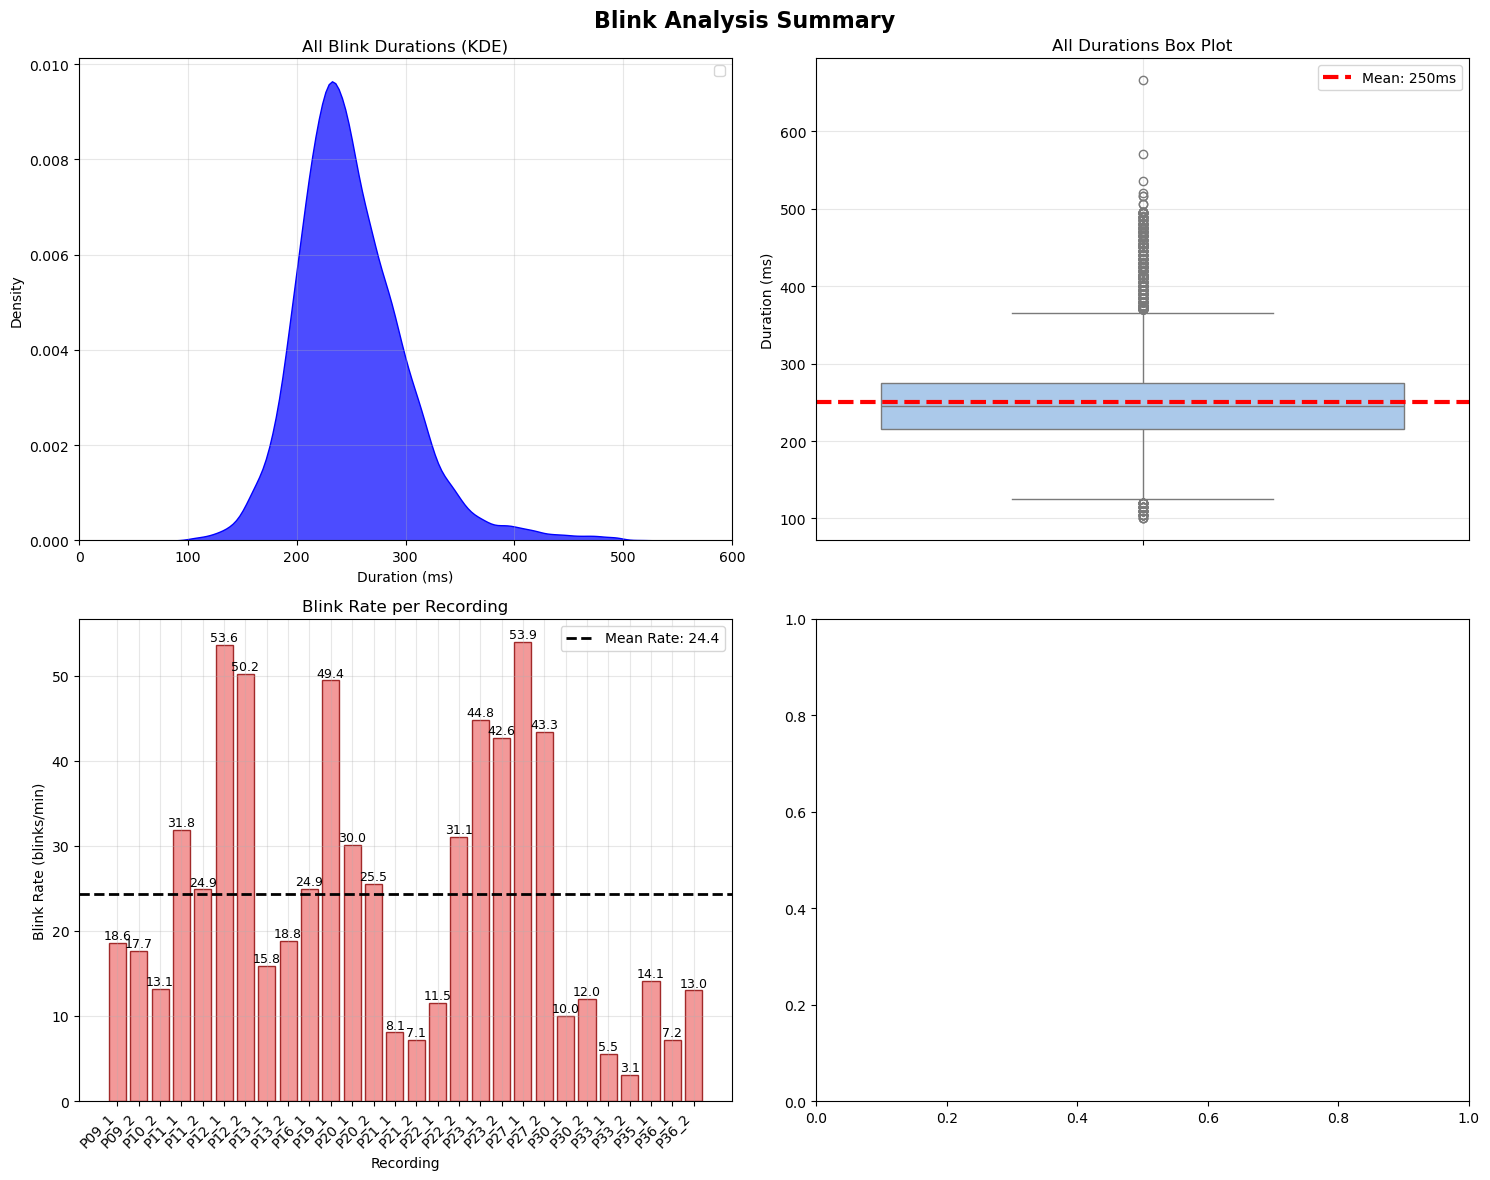

In [10]:
fig2, axes2 = plt.subplots(2,2, figsize=(15, 12))
# All durations KDE
overall_mean = np.mean(all_durations)
sns.kdeplot(all_durations, ax=axes2[0,0], color='blue', fill=True, alpha=0.7)
axes2[0,0].set_title('All Blink Durations (KDE)')
axes2[0,0].set_xlabel('Duration (ms)')
axes2[0,0].set_ylabel('Density')
axes2[0,0].set_xlim(0, 600)
axes2[0,0].grid(True, alpha=0.3)
axes2[0,0].legend()

# All durations box plot
sns.boxplot(y=all_durations, ax=axes2[0,1], palette="pastel")
axes2[0,1].axhline(overall_mean, color='red', linestyle='--', linewidth=3, 
                   label=f'Mean: {overall_mean:.0f}ms')
axes2[0,1].set_title('All Durations Box Plot')
axes2[0,1].set_ylabel('Duration (ms)')
axes2[0,1].grid(True, alpha=0.3)
axes2[0,1].legend()

# Blink rate per subject (bar plot)
blink_df = pd.DataFrame(blink_rates_data)
subjects = sorted(blink_df['Recording'].unique())
rates = [blink_df[blink_df['Recording'] == sub]['Rate'].iloc[0] for sub in subjects]
mean_rate = np.mean(rates)

bars = axes2[1,0].bar(range(len(subjects)), rates, color='lightcoral', 
                      edgecolor='darkred', alpha=0.8)
axes2[1,0].axhline(mean_rate, color='black', linestyle='--', linewidth=2, 
                   label=f'Mean Rate: {mean_rate:.1f}')
axes2[1,0].set_title('Blink Rate per Recording')
axes2[1,0].set_xlabel('Recording')
axes2[1,0].set_ylabel('Blink Rate (blinks/min)')
axes2[1,0].set_xticks(range(len(subjects)))
axes2[1,0].set_xticklabels([s[:8] for s in subjects], rotation=45, ha='right')
axes2[1,0].legend()
axes2[1,0].grid(True, alpha=0.3)

# Add rate values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes2[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{rates[i]:.1f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Blink Analysis Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
summary_data = []
for recording_data in blink_rates_data:
    recording = recording_data['Recording']
    durations = session_durations[recording]
    
    # Store as numeric first
    stats = {
        'Recording': recording[:12],
        'N_Blinks': recording_data['N_Blinks'],
        'Mean_Dur_ms': np.mean(durations),        
        'Std_Dur_ms': np.std(durations),          
        'Blink_Rate': recording_data["Rate"],     
        'Min_ms': np.min(durations),              
        'Max_ms': np.max(durations)              
    }
    summary_data.append(stats)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df[['Recording', 'N_Blinks', 'Mean_Dur_ms', 'Std_Dur_ms', 
                        'Blink_Rate', 'Min_ms', 'Max_ms']]

n_blinks_list = [d['N_Blinks'] for d in blink_rates_data]

print(f"OVERALL STATISTICS")
print(f"Total blinks: {len(all_durations):,}")
print(f"Mean duration: {np.mean(all_durations):.1f} ± {np.std(all_durations):.1f} ms")
print(f"Duration range: {np.min(all_durations):.0f} - {np.max(all_durations):.0f} ms")
print(f"Mean blink rate: {np.mean([d['Rate'] for d in blink_rates_data]):.1f} blinks/min")
print(f"Mean number of blinks: {np.mean(n_blinks_list):.1f}")
print(f"Std of number of blinks: {np.std(n_blinks_list):.1f}")
print(f"Blink count range: {np.min(n_blinks_list)} - {np.max(n_blinks_list)}")

summary_df


OVERALL STATISTICS
Total blinks: 26,447
Mean duration: 250.0 ± 50.4 ms
Duration range: 100 - 666 ms
Mean blink rate: 24.4 blinks/min
Mean number of blinks: 944.5
Std of number of blinks: 632.7
Blink count range: 106 - 2294


,Recording,N_Blinks,Mean_Dur_ms,Std_Dur_ms,Blink_Rate,Min_ms,Max_ms
0,P21_2,240,261.166667,43.678434,7.143855,185,455
1,P23_1,1910,224.282723,43.765303,44.822121,105,495
2,P27_1,2162,239.704440,44.461378,53.944767,150,490
3,P12_1,2294,247.226678,55.180279,53.598164,100,571
4,P10_2,505,303.348515,43.310956,13.141609,130,470
5,P16_1,959,242.081335,37.688029,24.915629,135,425
6,P33_1,195,226.153846,38.375031,5.535751,160,420
7,P22_2,1230,235.817073,29.861521,31.075840,125,495
8,P20_1,1138,230.667838,29.141079,30.043970,155,495
9,P09_2,664,297.391566,47.580151,17.687059,150,466


## Blinks&Saccades/Fixations ## 

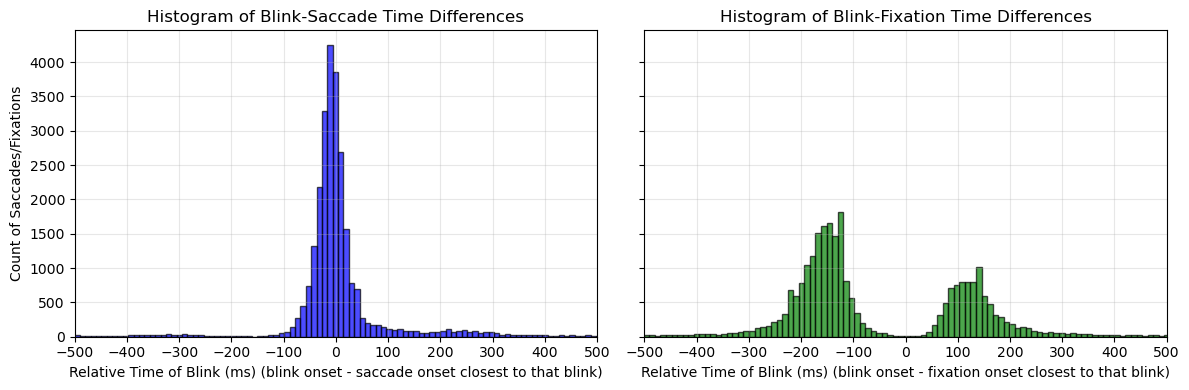

In [ ]:
## 2 histogram plots (for fixations and saccades vs blinks) with relative time of blinks on the X axis and fixation or saccade frequency on the y axis

base_path = 
# initiate df for all sessions combined
df_blinks_saccades_all = pd.DataFrame()
df_blinks_fixations_all = pd.DataFrame()

# loading files
for folder in os.listdir(base_path):
    participant_path = os.path.join(base_path, folder)
    if not os.path.isdir(participant_path):
        continue
    blinks_path = os.path.join(participant_path, 'blinks.csv')
    saccades_path = os.path.join(participant_path, 'saccades.csv')
    fixations_path = os.path.join(participant_path, 'fixations.csv')
  
    try:
        df_blinks = pd.read_csv(blinks_path)
        df_saccades = pd.read_csv(saccades_path)
        df_fixations = pd.read_csv(fixations_path)
    except Exception as e:
        print('Failed to read', blinks_path, e)
        continue

    # rename duration column to avoid same names
    df_saccades = df_saccades.rename(columns={'start timestamp [ns]': 'saccade_start_timestamp [ns]'})
    df_fixations = df_fixations.rename(columns={'start timestamp [ns]': 'fixation_start_timestamp [ns]'})

    # Sort by timestamp (should be sorted already, but in case for proper merging)
    df_blinks = df_blinks.sort_values("start timestamp [ns]")
    df_saccades = df_saccades.sort_values("saccade_start_timestamp [ns]")
    df_fixations = df_fixations.sort_values("fixation_start_timestamp [ns]")

    # Merge-asof to assign the closest frame_id to each fixation
    blinks_with_saccades = pd.merge_asof(
    df_blinks,
    df_saccades,
    left_on="start timestamp [ns]",
    right_on="saccade_start_timestamp [ns]",
    direction='nearest')  # 'nearest' to match the closest timestamp from both directions 

    blinks_with_fixations = pd.merge_asof(
    df_blinks,
    df_fixations,
    left_on="start timestamp [ns]",
    right_on="fixation_start_timestamp [ns]",
    direction='nearest')  # 'nearest' to match the closest timestamp from both directions #'backward' is closesnt following blink

    # Calculate time difference between blink start and saccade start
    blinks_with_saccades['time_diff_ns'] = blinks_with_saccades['start timestamp [ns]'] - blinks_with_saccades['saccade_start_timestamp [ns]']
    blinks_with_fixations['time_diff_ns'] = blinks_with_fixations['start timestamp [ns]'] - blinks_with_fixations['fixation_start_timestamp [ns]']


    # append to all sessions df
    df_blinks_saccades_all = pd.concat([df_blinks_saccades_all, blinks_with_saccades], ignore_index=True)
    df_blinks_fixations_all = pd.concat([df_blinks_fixations_all, blinks_with_fixations], ignore_index=True)    

    
    """ # histograms per session
    # Plot histogram for saccades vs blinks
    plt.figure(figsize=(10,6))
    plt.hist(blinks_with_saccades['time_diff_ns'] / 1e6, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Participant: {folder} - Histogram of Blink-Saccade Time Differences')
    plt.xlabel('Relative Time of Blink (ms) (blink onset - saccade preceeding blink onset)')
    plt.ylabel('Count of Saccades')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot histogram for fixations vs blinks
    plt.figure(figsize=(10,6))
    plt.hist(blinks_with_fixations['time_diff_ns'] / 1e6, bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title(f'Participant: {folder} - Histogram of Blink-Fixation Time Differences')
    plt.xlabel('Relative Time of Blink (ms) (blink onset - fixation preceeding blink onset)')
    plt.ylabel('Count of Fixations')
    plt.grid(True, alpha=0.3)
    plt.show()
    """

# histograms for all sessions combined
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

# Plot histogram for saccades vs blinks
axes[0].hist(df_blinks_saccades_all['time_diff_ns'] / 1e6, bins=500, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Blink-Saccade Time Differences')
axes[0].set_xlabel('Relative Time of Blink (ms) (blink onset - saccade onset closest to that blink)')
axes[0].set_ylabel('Count of Saccades/Fixations')
axes[0].set_xlim(-500, 500)
axes[0].set_xticks(np.arange(-500, 501, 100))
axes[0].grid(True, alpha=0.3)

# Plot histogram for fixations vs blinks
axes[1].hist(df_blinks_fixations_all['time_diff_ns'] / 1e6, bins=500, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Histogram of Blink-Fixation Time Differences')
axes[1].set_xlabel('Relative Time of Blink (ms) (blink onset - fixation onset closest to that blink)')
axes[1].set_xlim(-500, 500)
axes[1].set_xticks(np.arange(-500, 501, 100))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


